# Quantum Fourier Transform (QFT)

**Goal:**  
Show three ways to build the \(n\)-qubit QFT in Qiskit—  
1) an *iterative* implementation,  
2) a *recursive* one, and  
3) Qiskit’s built-in `QFT` gate.  


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

from math import pi

## Iterative implementation

In [2]:
def qft_iterative(circuit: QuantumCircuit, n: int):
    # 1) Apply the Hadamard & controlled-phase layers
    #    for each 'target' qubit j = 0..n-1:
    for j in range(n):
        # 1a) Hadamard on qubit j
        circuit.h(j)
        
        # 1b) Controlled-phase rotations from qubits k > j onto j
        #     The phase angle is π / 2^(k-j)
        for k in range(j + 1, n):
            angle = pi / (2 ** (k - j))
            circuit.cp(angle, control_qubit=k, target_qubit=j)
        
        circuit.barrier()

    # 2) Bit-reversal: swap qubit i with qubit (n-1-i)
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)

    circuit.barrier()

    return circuit
   

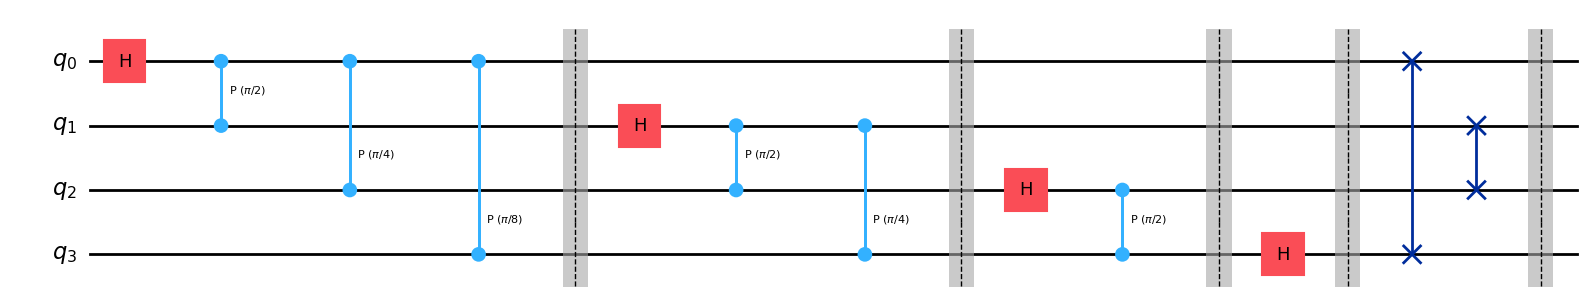

In [3]:
qc = QuantumCircuit(4)
qft_iterative(qc, 4)

qc.draw('mpl')


## Recursive implementation

In [4]:
def qft_recursive(circuit: QuantumCircuit, n: int, offset: int = 0):
    if n <= 0:
        return circuit

    # 1) Hadamard on the most-significant qubit of this block
    circuit.h(offset)

    # 2) Controlled-phase rotations from the other qubits in this block
    for i in range(1, n):
        angle = pi / (2**i)
        circuit.cp(angle, offset + i, offset)

    circuit.barrier()

    # 3) Recurse on the remaining n-1 qubits
    return qft_recursive(circuit, n - 1, offset + 1)


def qft_recursive_full(circuit: QuantumCircuit, n: int) -> QuantumCircuit:
    # Run the recursive routine on qubits [0..n-1]
    qft_recursive(circuit, n, offset=0)

    # Reverse the qubit order (bit-reversal)
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)

    circuit.barrier()
    return circuit

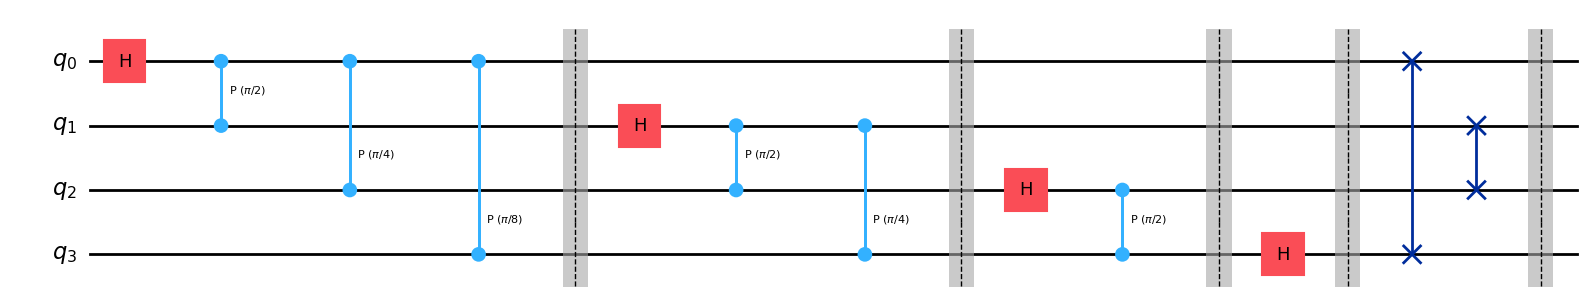

In [5]:
qc = QuantumCircuit(4)
qft_recursive_full(qc, 4)

qc.draw('mpl')


## In-built implementation


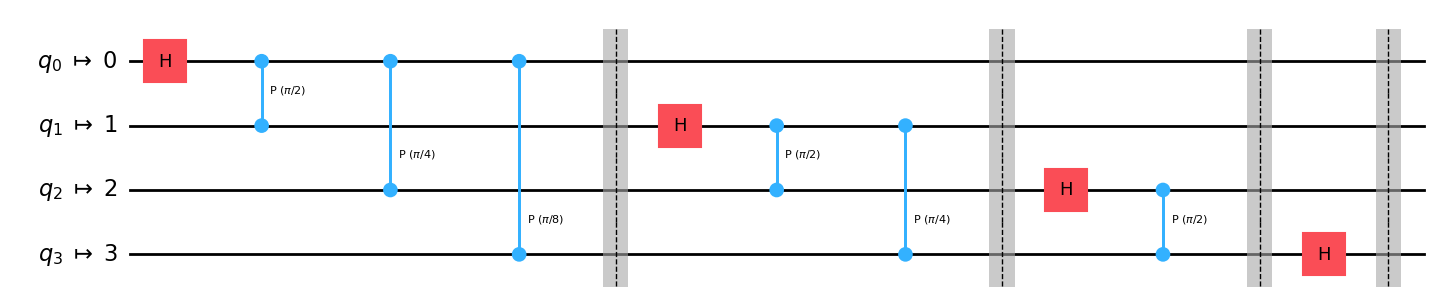

In [6]:
qc = QuantumCircuit(4)

# Instantiate the built-in QFT gate for 4 qubits, with automatic bit-reversal swaps and barriers between stages
qft = QFT(4, do_swaps=True, insert_barriers=True)

# Append the QFT to our circuit.
# We reverse the qubit list so that qubit 0 is treated as the MSB by the QFT.
qc.append(qft, list(reversed(range(4))))

# Transpile for the Aer simulator backend to see the actual gates
qc_transpiled = transpile(qc, backend=AerSimulator())

qc_transpiled.draw('mpl')
